In [1]:
import numpy as np
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
from src.helpers import pickle_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.5
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

# CAMB

In [24]:
NDIM = 7 
camb_samples_1 = pickle_load('samples', 'camb_samples_corrected_neutrino_1')
# camb_samples_2 = pickle_load('samples', 'camb_samples_corrected_neutrino_2')
camb_samples_2 = pickle_load('samples', 'camb_samples_uniform_planck_priors')

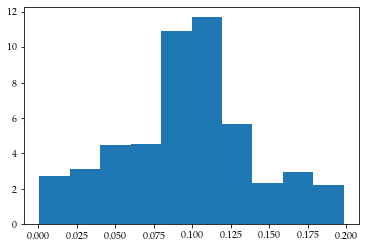

In [35]:
plt.hist(camb_samples_2[:,-1][camb_samples_2[:,-1] < 0.20], density = True)
plt.show()

In [25]:
labels = [r'$\Omega_{b}h^{2}$', 
          r'$\Omega_{cdm}h^{2}$', 
          r'$100\theta_{MC}$', 
          r'$\tau$', 
          r'$ln(10^{10})A_{s}$', 
          r'$n_{s}$',
          r'$\sum m_{\nu}$']
names = ["x%s"%i for i in range(NDIM)]

In [26]:
samples_1 = MCSamples(samples=camb_samples_1,names = names, labels = labels, settings = settings, label = 'CAMB 1')
samples_2 = MCSamples(samples=camb_samples_2,names = names, labels = labels, settings = settings, label = 'CAMB 2')

Removed no burn in
Removed no burn in


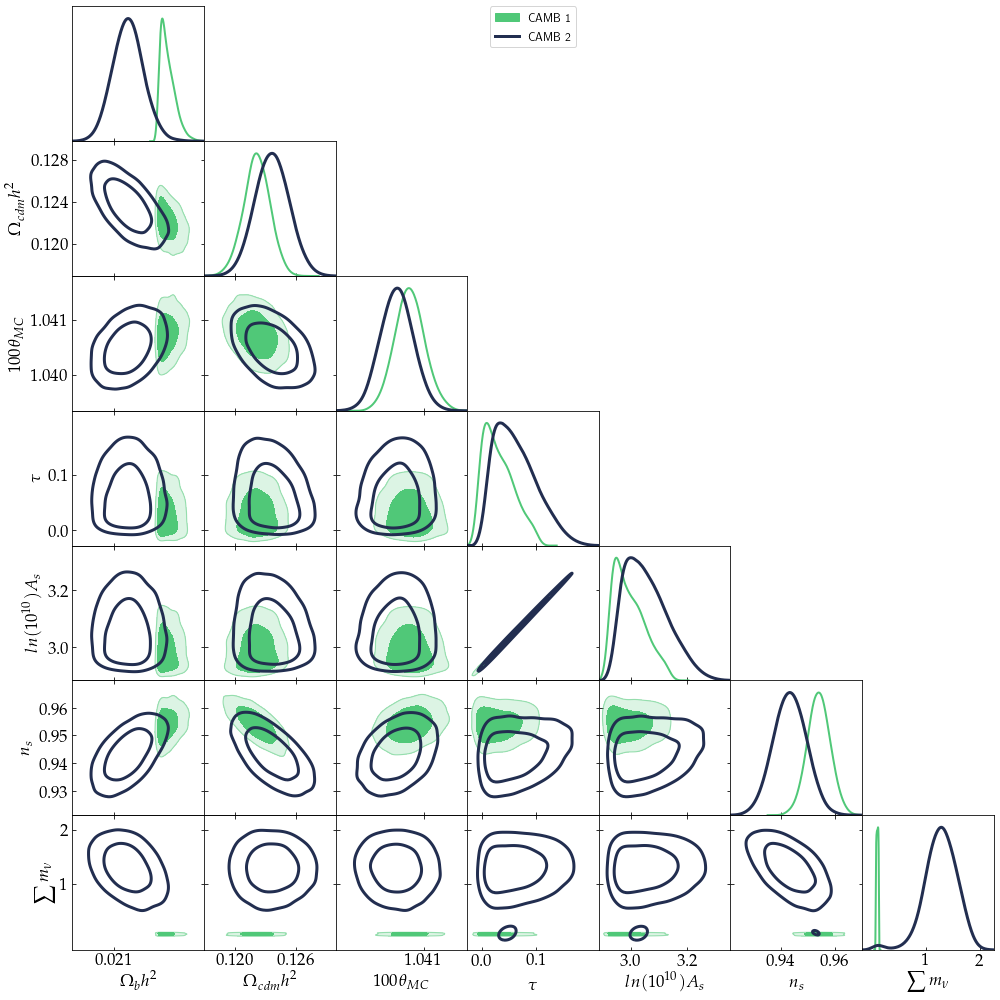

In [27]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[color1, color3], contour_lws=[2,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# Emulator and CAMB (Without Neutrino)

- Multivariate normal priors

In [4]:
NDIM = 6

In [5]:
camb_samples = np.loadtxt('samples/camb_samples_1.txt')

samples_gp = pickle_load('samples', 'samples_GP_multivariate_2500_1')
samples_gp_thin = samples_gp.get_chain(discard=100, thin=2, flat=True)

### Triangle Plot

In [6]:
labels = [r'$\Omega_{b}h^{2}$', r'$\Omega_{cdm}h^{2}$', r'$100\theta_{MC}$', r'$\tau$', r'$ln(10^{10})A_{s}$', r'$n_{s}$']#, r'$H_{0}$']
names = ["x%s"%i for i in range(NDIM)]

In [7]:
samples_1 = MCSamples(samples=camb_samples,names = names, labels = labels, settings = settings, label = 'CAMB')
samples_2 = MCSamples(samples=samples_gp_thin,names = names, labels = labels, settings = settings, label = 'Emulator')

Removed no burn in
Removed no burn in


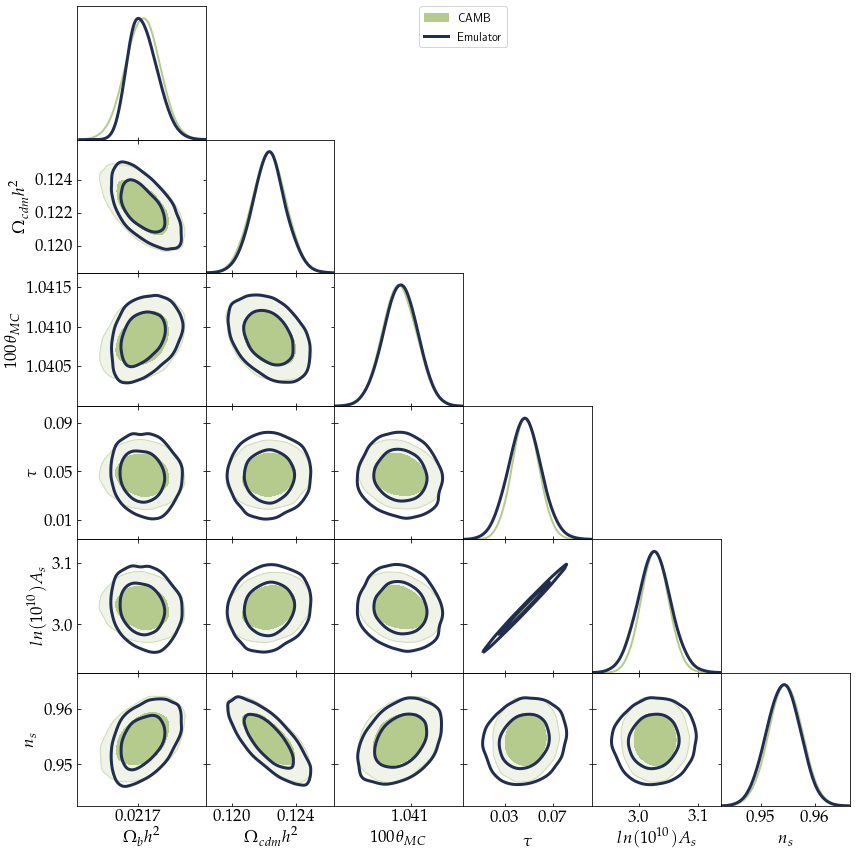

In [10]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[c1, c3], contour_lws=[2,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# Accuracy

In [11]:
acc_2500 = pickle_load('accuracies', 'acc_2500')

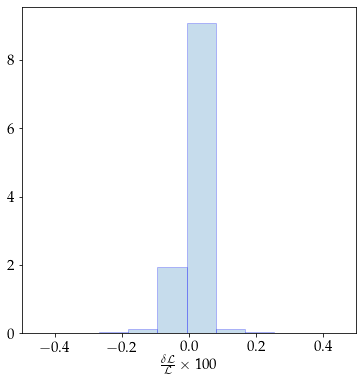

In [12]:
plt.figure(figsize=(6,6))
plt.hist(acc_2500*100, density=True, bins = 20, edgecolor = 'b', alpha = 0.25)
plt.xlabel(r'$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-0.5, 0.5)
plt.show()